# Automatic number plate recognition

## Problem statement and data introduction

### Case description

Nowadays, security has become one of the biggest concerns for any organization, and automation of such security is of great importance. For example, in the modern world, companies and organizations want to automate many tasks related to control and monitoring as much as possible. However, many of the existing solutions are still not reliable in real situations, usually depending on many limitations.

As a CV case, we propose to create a part of the automatic recognition system of vehicle license plates.

> Automatic/Automated License Plate Recognition, ALPR — This is the identification of a part of a vehicle that is suspected to be a license plate. In other words, it is an artificial intelligence technology that uses optical character recognition in images to read vehicle registration plates and create vehicle location data.

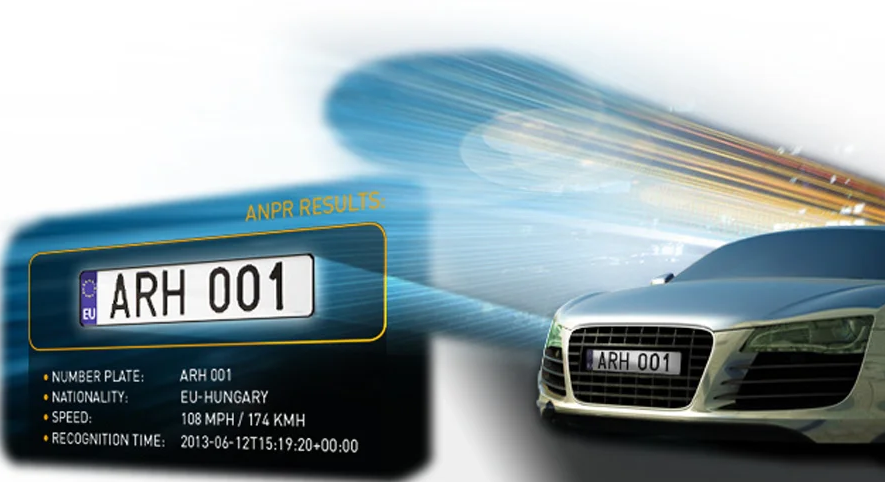

This technology typically uses traffic enforcement cameras or cameras specifically designed for this task.

ALPR technology is used in many areas, here are some examples:

* in parking lots to record license plates of parked cars;
* at checkpoints to record license plates of vehicles entering and leaving a business;
* by law enforcement on the road to identify vehicles violating traffic rules or to verify that a vehicle is registered or licensed;
* for traffic control and electronic toll collection on toll roads, such as by road agencies.

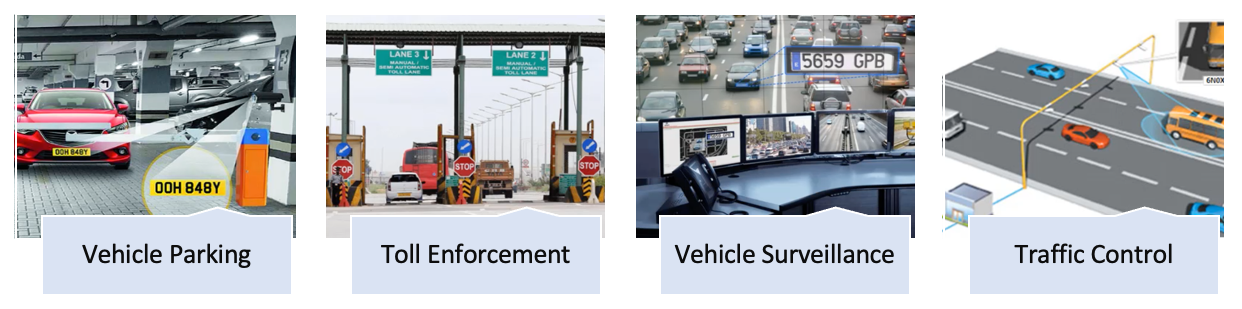

In general, to identify a vehicle license plate, the following steps must be completed:

* License plate detection in the image.<br>
At this stage, we need to develop an algorithm that will be responsible for finding and highlighting the license plate in the image. If we translate the task into Computer Vision terms, then, in essence, at this stage we need to build a model that solves the detection problem - highlighting the location of the license plate in the photo.

* Orientation and calibration of the license plate.<br>
At this stage, the skew of the license plate is compensated for and the size of the resulting image is corrected in accordance with the required size.

* Normalization.<br>
At this stage, the brightness and contrast of the image are adjusted to increase the likelihood of correct recognition of the text in the photo.

* Segmentation of characters. <br>
At this stage, we need to find individual characters on the license plates. That is, in essence, we need to break the text in the image into individual characters. In the case of printed text, where there is always some distance between the characters, this is a fairly simple task. But for handwritten text everything is much more complicated, here it is necessary to use specialized methods, but now is not about them.

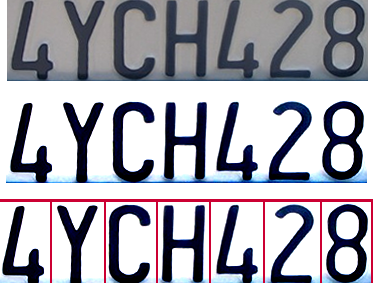

* Optical character recognition. <br>
When each character is selected, it needs to be recognized. This is far from a simple task. In essence, at this stage we convert the image of the license plate into a first approximation of the text.

* Syntactic/geometric analysis. <br>
After receiving the text, it needs to be checked for correctness. The characters and positions are checked for compliance with the specialized rules of a particular country.

* Averaging the recognized value. <br>
Making a decision based on one frame is a bad idea. The results can be greatly distorted due to the quality of the image, glare due to reflected light, incorrect angle, etc. Therefore, to obtain more accurate and reliable results, the recognition procedure (steps 1-6) is repeated several times.

The final result of the ALPR system is created by averaging the results of the algorithm for several images obtained at a certain time interval.

### About the dataset

To solve our problem, we need a dataset of images of cars from different angles and under different lighting conditions with the locations of license plates marked as bounding boxes.

To be specific, we will work with the [Car License Plate Detection](https://www.kaggle.com/datasets/andrewmvd/car-plate-detection) dataset, hosted on our favorite platform Kaggle.

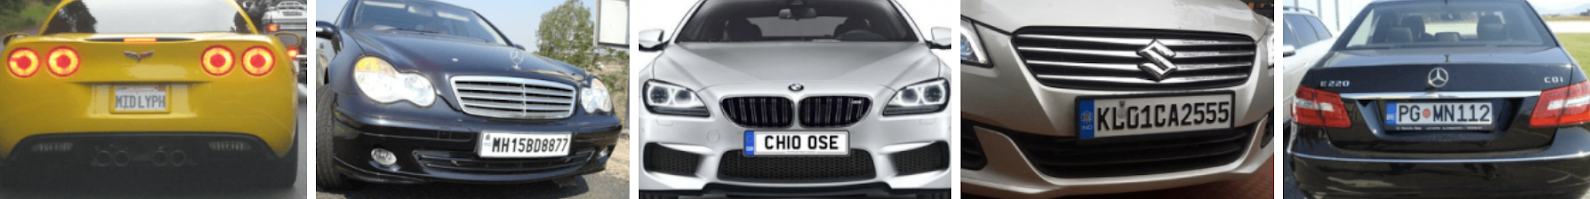

This dataset contains 433 unique images with annotations of the bounding boxes of the license plates within the image. Moreover, one image may contain several cars at once, and therefore several license plates.

The annotations are provided in the PASCAL VOC format.

### Getting to Know the Data

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torch
from sklearn.model_selection import train_test_split
import os
import glob
import xml.etree.ElementTree as ET 
from tqdm.auto import tqdm
import shutil as sh
import warnings
warnings.filterwarnings('ignore')

In [29]:
# Let's check that the video card is available to us
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 4070 SUPER


In [30]:
DATASET_PATH = "data"
ANNOTATIONS_PATH = os.path.join(DATASET_PATH, "annotations")
IMAGES_PATH = os.path.join(DATASET_PATH, "images")
print(ANNOTATIONS_PATH)
print(IMAGES_PATH)

data/annotations
data/images


Let's look at an example image. To display the image on the screen, we will use the imshow() function from the matplotlib library. To read the image, you need to pass the path to the image to it. The path can be relative (relative to the working directory) or absolute (set relative to the root directory of the project).

The result of reading will be a numpy array of dimension (HEIGHT, WIDTH, CHANNEL), where:

* HEIGHT - image height (in pixels)
* WIDTH - image width (in pixels)
* CHANNEL - number of channels

All images in the dataset are color, that is, they have three channels (consist of three two-dimensional matrices) - RGB (Red, Green, Blue). The values ​​of each of the three matrices are the pixel intensity values.

Image shape: (398, 530, 3)


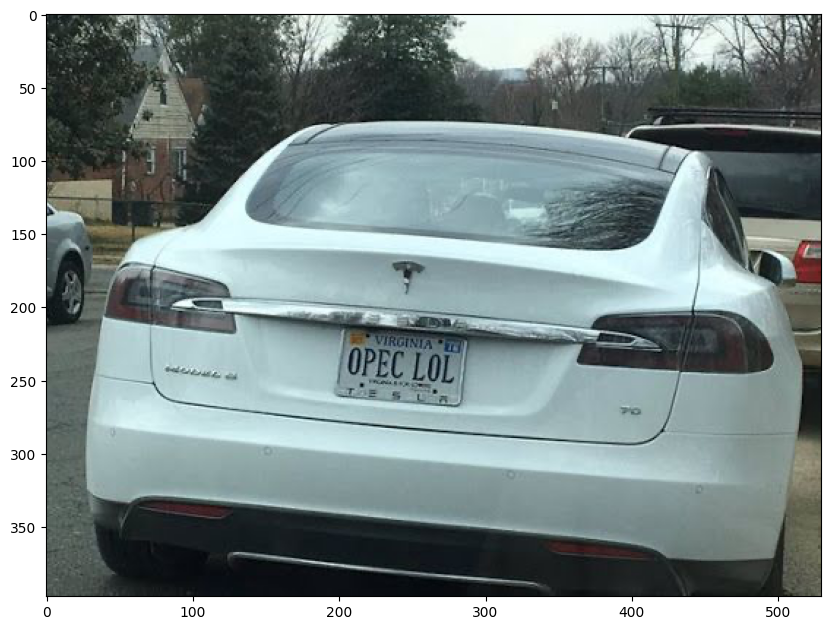

In [31]:
# Составляем путь до файла: /путь/до/папки/имя_изображения.png
image_filename = 'Cars129.png'
image_path = os.path.join(IMAGES_PATH, image_filename)
# Читаем изображение
img = plt.imread(image_path)
# Создаём фигуру и координатную плоскость
fig, ax = plt.subplots(figsize=(10, 8))
# Выводим изображение на экран
ax.imshow(img);
# Выводим размер изображения
print('Image shape: {}'.format(img.shape))

Now let's look at an example of annotation for this image.

In [32]:
# Let's read one of the annotation files and look at its contents.
with open(os.path.join(ANNOTATIONS_PATH, 'Cars129.xml')) as f:
    print(f.read())


<annotation>
    <folder>images</folder>
    <filename>Cars129.png</filename>
    <size>
        <width>530</width>
        <height>398</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>licence</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>204</xmin>
            <ymin>213</ymin>
            <xmax>282</xmax>
            <ymax>267</ymax>
        </bndbox>
    </object>
</annotation>


When using PASCAL VOC format annotation, the following tags are specified:

* `<annotation>` - root title
* `<folder>` - folder with image
* `<filename>` - file name
* `<size>` - size information
* * `<width>` - width
* * `<height>` - height
* * `<depth>` - depth (number of channels)

* `<segmented>` - this field specifies information for segmentation. That is, whether the images contain non-linear (irregular) shaped annotations, usually called polygons (we do not have any, all frames are rectangular, so 0 is set)
* `<object>` - information for detecting objects
* * `<name>` - class name (in our case, license plate).
* * `<pose>` - specifies the asymmetry or orientation of the image. By default, it is specified as Unspecified, which means that the image is not distorted.
* * `<truncated>` - indicates whether the object is fully or partially visible (can be 0 or 1 respectively)
* * `<occluded>`- information about the absorption of classes by each other (this is when inside the bounding rectangle of class A, there is a bounding rectangle of class B)
* * `<difficult>` - Indicates whether it is difficult to recognize the object in the image (can be 0 - easy or 1 - difficult).
* * `<bndbox>` - these are the coordinates that determine the location of the object (in our case, the license plate). These coordinates are contained in the child tags `<xmin>`, `<ymin>`, `<xmax>`, `<ymax>`. The annotation stores the coordinates of the upper left and lower right positions of the object.

For further convenience, let's create a DataFrame in which we will store the following columns:

* *filename* - file name (without extension)
* *xmin*, *xmax* - minimum and maximum coordinates of the frame along the x axis
* *ymin*, *ymax* - minimum and maximum coordinates of the frame along the y axis
* *width*, *height* - width and height of the image

To do this, we will use the following code for parsing XML files with annotations:

In [33]:
df_dict = {
    "filename":[], "xmin":[], "ymin":[],   
    "xmax":[],"ymax":[], "name":[],    
    "width":[], "height":[],
}

for annotation in glob.glob(ANNOTATIONS_PATH+"/*.xml"):
    tree = ET.parse(annotation)
    filename = tree.find('filename').text
    for elem in tree.iter():
        if 'size' in elem.tag:
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    
        if 'object' in elem.tag:
            for attr in list(elem):
                if 'name' in attr.tag:
                    name = attr.text                 
                    df_dict['name'] += [name]
                    df_dict['width'] += [width]
                    df_dict['height'] += [height] 
                    df_dict['filename'] += [filename]
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            df_dict['xmin'] += [xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            df_dict['ymin'] += [ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            df_dict['xmax'] += [xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            df_dict['ymax'] += [ymax]

In [34]:
df = pd.DataFrame(df_dict)
df.head()

filename  xmin  ymin  xmax  ymax     name  width  height
0   Cars50.png   116    55   525   262  licence    590     350
1   Cars89.png   307   206   345   221  licence    400     262
2   Cars89.png   227   222   253   230  licence    400     262
3  Cars155.png   150   177   203   190  licence    400     267
4  Cars156.png   114    78   230   102  licence    400     200

In [35]:
print('Data shape: {}'.format(df.shape))
print('Count of unique images: {}'.format(df['filename'].nunique()))
print('Count of classes: {}'.format(df['name'].unique()))

Data shape: (471, 8)
Count of unique images: 433
Count of classes: ['licence']


We see that we have 471 annotations in total, but fewer unique images - 433. This means that one image can contain several license plates at once. An important feature of the dataset!

We also see that we have only one class in the data - licence (license plate). This means that when performing detection, we will solve a binary classification problem - distinguish the class of the license plate from the background (everything that is not a license plate).

Now that we have parsed the coordinates of the bounding boxes, let's choose an image from the dataset and display it along with the annotation. That is, add a bounding box on top of the image.

[204] [213] [78] [54]


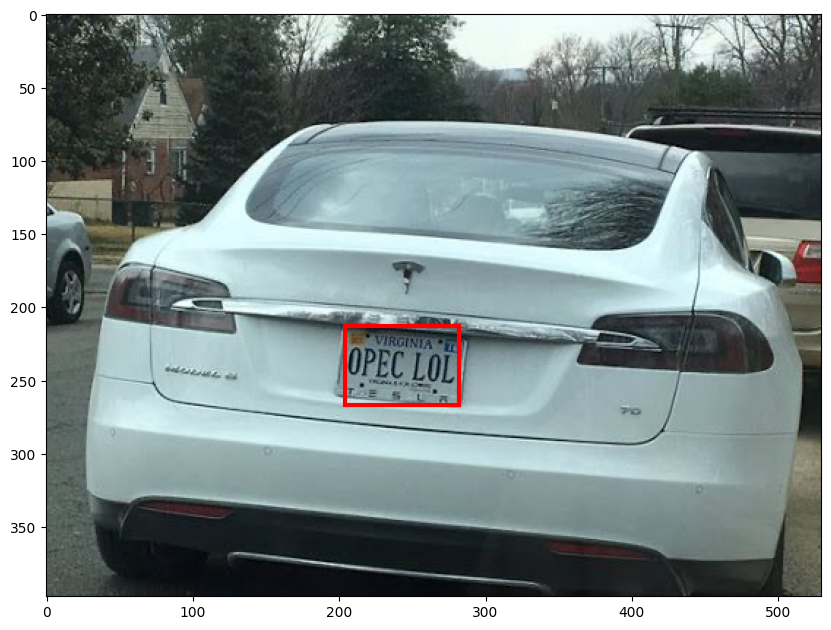

In [36]:
# Составляем путь до файла — /путь/до/папки/имя_изображения.png
image_filename = 'Cars129.png'
image_path = os.path.join(IMAGES_PATH, image_filename)
# Читаем изображение
img = plt.imread(image_path)
# Создаём фигуру и координатную плоскость
fig, ax = plt.subplots(figsize=(10, 8))
# Выводим изображение на экран
ax.imshow(img);

# Находим индекс картинки в DataFrame
image_idx = df[df['filename'] == image_filename].index

# Находим координаты левой нижней точки
x_min = df.loc[image_idx, 'xmin'].values
y_min = df.loc[image_idx, 'ymin'].values
# Находим ширину и высоту рамки
box_width = (df.loc[image_idx, 'xmax'] - df.loc[image_idx, 'xmin']).values
box_height = (df.loc[image_idx, 'ymax'] - df.loc[image_idx, 'ymin']).values
print(x_min, y_min, box_width, box_height)

# Так как ограничивающих прямоугольников может быть несколько, создаём цикл по всем.
for i in range(len(image_idx)):
    # Строим прямоугольник
    rect = patches.Rectangle(
        (x_min[i], y_min[i]), #координаты опорной точки
        box_width[i], #ширина прямоугольника
        box_height[i], #высота прямоугольника
        linewidth=3, #ширина линии
        edgecolor='r', #цвет
        facecolor='none' #заливка (none — отсутствует)
    )
    # Накладываем прямоугольник поверх изображения
    ax.add_patch(rect);

For the convenience of further work, we will wrap all this code for image visualization in a function, let's call it plot_bounding_box(). The function will accept the name of the file with the desired image and a DataFrame with coordinates and display the image on the screen:

In [37]:
def plot_bounding_box(image_folder, image_filename, df=df):
    image_path = os.path.join(image_folder, image_filename)
    img = plt.imread(image_path)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(img);

    image_idx = df[df['filename'] == image_filename].index

    x_min = df.loc[image_idx, 'xmin'].values
    y_min = df.loc[image_idx, 'ymin'].values
    box_width = (df.loc[image_idx, 'xmax'] - df.loc[image_idx, 'xmin']).values
    box_height = (df.loc[image_idx, 'ymax'] - df.loc[image_idx, 'ymin']).values
    for i in range(len(image_idx)):
        rect = patches.Rectangle(
            (x_min[i], y_min[i]), 
            box_width[i], 
            box_height[i], 
            linewidth=3, 
            edgecolor='r', 
            facecolor='none'
        )
        ax.add_patch(rect);

Let's check how our code works for the case of several bounding boxes. Let's take the image 'Car330.png', substitute its name into the image_filename argument of the plot_bounding_box() function and get:

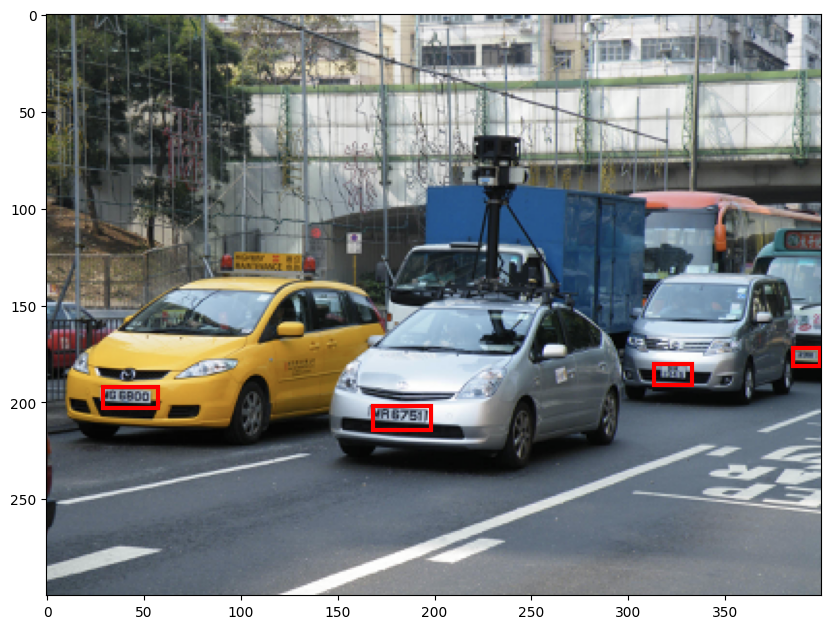

In [38]:
plot_bounding_box(image_folder=IMAGES_PATH, image_filename='Cars330.png', df=df)

Let's call the plot_bounding_box() function several times and look at the images. For example, let's call the function three times on three random images (you can specify any number):

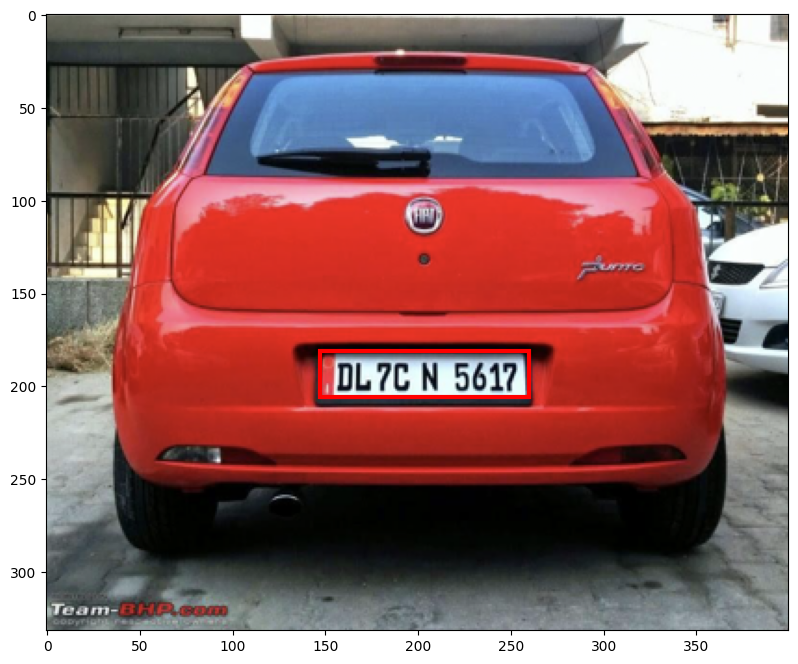

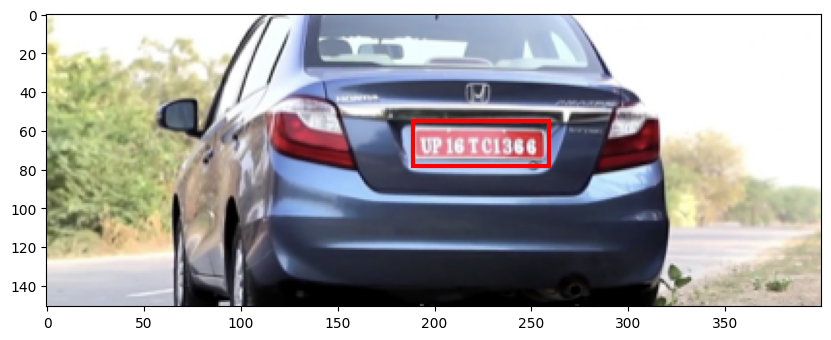

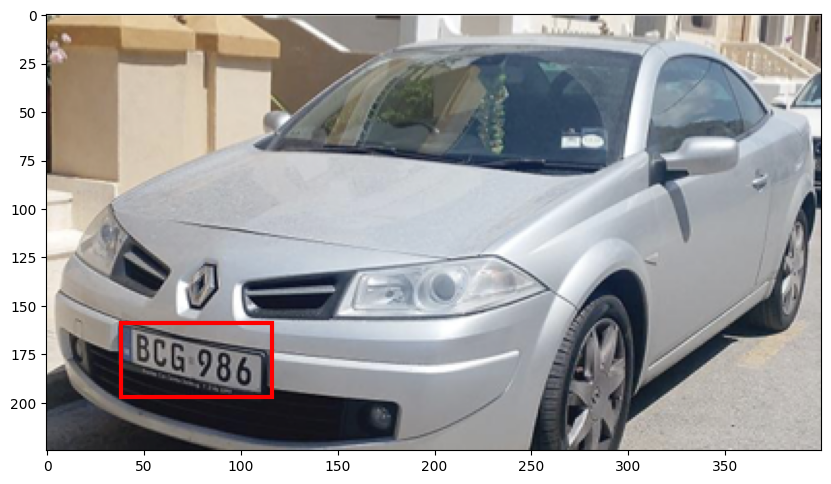

In [39]:
count = 3
for i in range(count):
    random_image_idx = np.random.choice(df.shape[0])
    image_filename = df.loc[random_image_idx, 'filename']
    plot_bounding_box(IMAGES_PATH, image_filename, df)

In [40]:
df[df['filename']=='Cars173.png']

filename  xmin  ymin  xmax  ymax     name  width  height
359  Cars173.png   170   118   252   163  licence    400     226

### Selecting a model

So, we have already decided that at the first stage of constructing the ALPR system algorithm, we solve the detection problem - selecting the location of the object of interest to us from the image, in our case - the license plate of a vehicle.

As we have already discussed earlier, there are at least two classes of models for solving the detection problem: one-stage and two-stage. Today, the undisputed leader is the one-stage model, and one of the most popular and most accurate are the YOLO family of models.

What is YOLO?

> YOLO (abbr. from “You Only Look Once”) is a modern deep learning method for object detection tasks (both detection and segmentation), which is based on convolutional neural networks. The first version of the algorithm was developed in 2016 and as of the beginning of 2023, at least 8 generally accepted modifications of this model have already been released, each of which has its own advantages and disadvantages. Therefore, YOLO is a whole family of neural network architectures for solving detection and segmentation problems!

Without going into details, the key idea of ​​YOLO is that the original image is divided into small sections (they are also called cells/samples/tiles) of SxS pixels in size (for different versions of YOLO, the S parameter may be different).

Each resulting section becomes a potential bounding box. That is, inside each cell, several frames are “drawn” using a special method to determine the object of different widths and heights (and it is also possible to add rotation), the positions of these frames are calculated relative to the center of the cell.

On the resulting sections, using a specialized convolutional neural network architecture, a probability distribution map is built for each of the classes in each section, that is, the probability of the presence of each class is determined in each section. After that, the results are combined in a specialized way and we get a solution to the detection problem - the bounding boxes we need.

The general (high-level) scheme of YOLO operation is shown in the figure below:

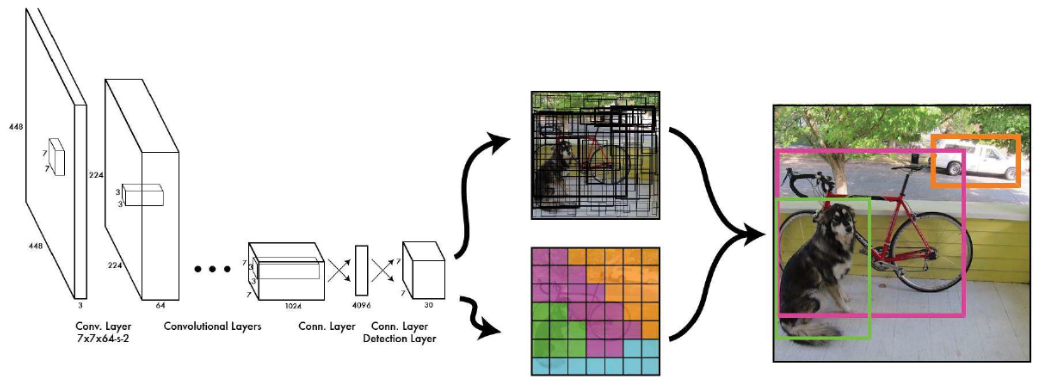

The main feature of the YOLO architecture is speed! YOLO allows you to recognize objects in an image in real time. The principle of YOLO involves entering the entire image at once, which passes through the convolutional neural network only once. That is why it is called “You only have to look once”. In other algorithms, this process occurs repeatedly, that is, the image passes through the CNN again and again. So YOLO has the advantage of high-speed object detection, which other algorithms cannot boast of.

And as you understand, in the task of building ALPR systems, speed is one of the main criteria!

### Preparing data for YOLO format

To train the model, you need to create a data configuration file in YAML format. It specifies the paths to folders with images and annotations that relate to the training, validation and test (optional) samples, as well as class names. Based on this, YOLOv5 from Ultralitics will understand where to get data files for training, validation and testing, respectively.

For example, let's say we have a root directory of the dataset, let's call it dataset:

```dataset
    └─dataset.yaml
    └─images
        └─train
            └─img1.png
            └─img2.png
        └─val
            └─img3.png
            └─img4.png
    └─labels
        └─train
            └─img1.txt
            └─img2.txt
        └─val
            └─img3.txt
            └─img4.txt        

In [41]:
DATA_PATH = "yolo"

LABELS_PATH = os.path.join(DATA_PATH, "labels")
IMGS_PATH = os.path.join(DATA_PATH, "images")

TRAIN_IMAGES_PATH = os.path.join(IMGS_PATH, "train")
VAL_IMAGES_PATH = os.path.join(IMGS_PATH, "val")
TRAIN_LABELS_PATH = os.path.join(LABELS_PATH, "train")
VAL_LABELS_PATH = os.path.join(LABELS_PATH, "val")

DATA_CONFIG_PATH = os.path.join(DATA_PATH, "dataset.yaml")

print(TRAIN_IMAGES_PATH)
print(VAL_IMAGES_PATH)
print(TRAIN_LABELS_PATH)
print(VAL_LABELS_PATH)
print(DATA_CONFIG_PATH)

yolo/images/train
yolo/images/val
yolo/labels/train
yolo/labels/val
yolo/dataset.yaml


In [42]:
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH) 
if not os.path.exists(TRAIN_IMAGES_PATH):
    os.makedirs(TRAIN_IMAGES_PATH)
if not os.path.exists(TRAIN_LABELS_PATH):
    os.makedirs(TRAIN_LABELS_PATH)
if not os.path.exists(VAL_IMAGES_PATH):
    os.makedirs(VAL_IMAGES_PATH)
if not os.path.exists(VAL_LABELS_PATH):
    os.makedirs(VAL_LABELS_PATH)

In [43]:
data_config = f'''
path: yolo
train: images/train
val: images/val
test:
names:
    0: licence
'''

with open(DATA_CONFIG_PATH, 'w') as f:
    f.write(data_config)

with open(DATA_CONFIG_PATH, 'r') as f:
    print(f.read())


path: yolo
train: images/train
val: images/val
test:
names:
    0: licence



We've sorted out the directory structure.

Now we need to fill them with content - images and annotations to them.

In [44]:
df['class'] = df['name'].map({'licence': 0})
df['x_center'] = (df['xmin'] + df['xmax']) / (2 * df['width'])
df['y_center'] = (df['ymin'] + df['ymax']) / (2 * df['height'])
df['box_width'] = (df['xmax'] - df['xmin']).abs() / df['width']
df['box_height'] = (df['ymax'] - df['ymin']).abs() / df['height']

df[['class','x_center','y_center','box_width','box_height']].head()

class  x_center  y_center  box_width  box_height
0      0   0.54322  0.452857    0.69322    0.591429
1      0   0.81500  0.814885    0.09500    0.057252
2      0   0.60000  0.862595    0.06500    0.030534
3      0   0.44125  0.687266    0.13250    0.048689
4      0   0.43000  0.450000    0.29000    0.120000

Great, we have prepared the data. Before writing new coordinates to files, let's create a training and validation sample.

Let's divide the entire set of images available to us into two in a ratio of 90/10. Please note that we must take into account that we can have several bounding boxes on one image. This means that we need unique files to create samples, otherwise it may turn out that the same images will end up in both the test and validation samples, and the model's evaluation based on the validation sample will be biased:

In [45]:
# Создаем общий список названий файлов с изображениями
image_ids = list(set(df['filename']))
# Разделяем этот список на два - тренировочную и валидационную выборку
train_ids, val_ids = train_test_split(image_ids, random_state=42, test_size=0.1)
# Посмотрим на размеры выборок
print('Train shape: {}'.format(len(train_ids)))
print('Validation shape: {}'.format(len(val_ids)))

Train shape: 389
Validation shape: 44


Finally, let's fill our folders:

* We'll fill the folders with annotations with txt files with the data format that we discussed above
* We'll fill the folders with images with images from the corresponding samples

In [46]:
# Создаем цикл по изображениям
for filename, mini in tqdm(df.groupby('filename')):
    # Если текущий файл находится в валидационной выборке
    if filename in val_ids:
        path2save = 'val'
    # В противном случае (тренировочная выборка)
    else:
        path2save = 'train'
    # Составляем путь до файла, куда запишем новую аннотацию
    new_annotation_path = os.path.join(LABELS_PATH, path2save, filename[:-4] + ".txt")
    # Открываем на запись с добавлением (w+) файл формата .txt
    with open(new_annotation_path, 'w+') as f:
        # Выделяем координаты bounding box в формате, требуемым для YOLOv5
        row = mini[['class','x_center','y_center','box_width','box_height']].astype(float).values
        row = row.astype(str)
        # Построчно записываем координаты каждого из bounding box на изображении
        for j in range(len(row)):
            text = ' '.join(row[j])
            f.write(text)
            f.write("\n")
    # Переносим в новую папку изображения из исходной папки
    sh.copy(
        os.path.join(IMAGES_PATH, filename),
        os.path.join(IMGS_PATH, path2save, filename)
    )

100%|██████████| 433/433 [00:00<00:00, 989.29it/s]


In [47]:
print(os.listdir(TRAIN_LABELS_PATH)[:30])
print(os.listdir(TRAIN_IMAGES_PATH)[:30])

['Cars312.txt', 'Cars269.txt', 'Cars35.txt', 'Cars309.txt', 'Cars300.txt', 'Cars251.txt', 'Cars33.txt', 'Cars50.txt', 'Cars265.txt', 'Cars248.txt', 'Cars327.txt', 'Cars237.txt', 'Cars23.txt', 'Cars324.txt', 'Cars425.txt', 'Cars333.txt', 'Cars34.txt', 'Cars257.txt', 'Cars12.txt', 'Cars202.txt', 'Cars388.txt', 'Cars205.txt', 'Cars368.txt', 'Cars406.txt', 'Cars292.txt', 'Cars89.txt', 'Cars67.txt', 'Cars413.txt', 'Cars349.txt', 'Cars158.txt']
['Cars254.png', 'Cars407.png', 'Cars186.png', 'Cars79.png', 'Cars23.png', 'Cars224.png', 'Cars304.png', 'Cars410.png', 'Cars98.png', 'Cars347.png', 'Cars353.png', 'Cars403.png', 'Cars21.png', 'Cars297.png', 'Cars388.png', 'Cars390.png', 'Cars4.png', 'Cars413.png', 'Cars72.png', 'Cars345.png', 'Cars55.png', 'Cars44.png', 'Cars358.png', 'Cars208.png', 'Cars204.png', 'Cars361.png', 'Cars91.png', 'Cars268.png', 'Cars319.png', 'Cars104.png']


0.0 0.15 0.761168384879725 0.06 0.024054982817869417
0.0 0.35875 0.7577319587628866 0.0475 0.024054982817869417
0.0 0.7475 0.7714776632302406 0.045 0.030927835051546393
0.0 0.95125 0.7371134020618557 0.0375 0.01718213058419244



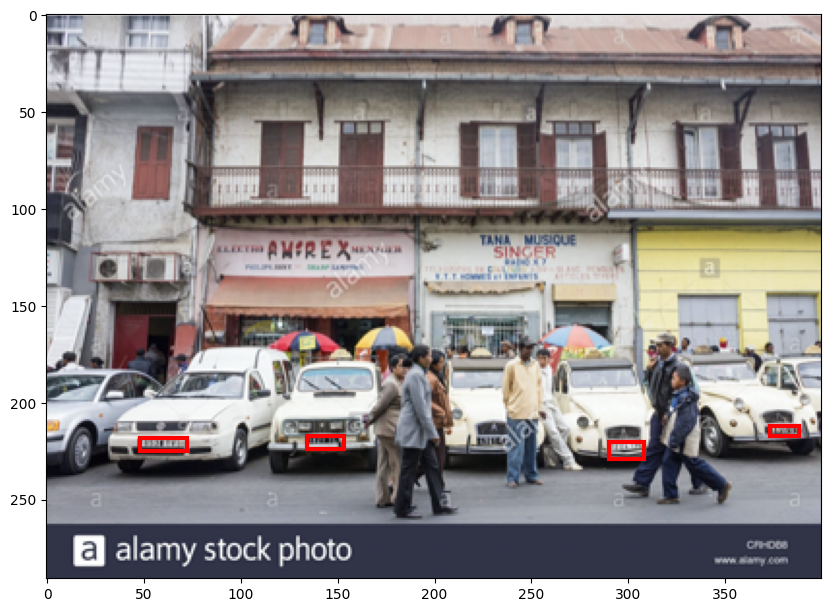

In [48]:
# Откроем файл с аннотацией и прочитаем содержимое
with open(os.path.join(TRAIN_LABELS_PATH, 'Cars277.txt')) as f:
    txt_example = f.read()
# Выведем содержимое на экран
print(txt_example)
# Посмотрим на то, как выглядит сама картинка
plot_bounding_box(TRAIN_IMAGES_PATH, 'Cars277.png', df)

Let's check that the number of annotations matches the number of images in each sample:

In [49]:
print(len(os.listdir(TRAIN_LABELS_PATH)) == len(os.listdir(TRAIN_IMAGES_PATH)))
print(len(os.listdir(VAL_LABELS_PATH)) == len(os.listdir(VAL_IMAGES_PATH)))

True
True


All done! We have prepared our dataset for training the YOLOv5 model. As a result, we should have the following folder structure:


```CV
CV_car_number_plate_detection
└─ data
│   ├── annotations
│   └── images
└─ yolo
│   ├── images
│   ├── labels
│   └── dataset.yaml
└─ .gitignore
└─ car.ipynb
└─ readme.md

```bash
# Клонируем репозиторий с моделью YOLO-v5
!git clone https://github.com/ultralytics/yolov5
# Устанавливаем зависимости, необходимые для работы модели
!pip install -qr yolov5/requirements.txt

In [50]:
# Перемещаемся в директорию yolov5
os.chdir('yolov5')
# Импортируем оттуда функцию init_seeds
from utils.general import init_seeds
#Фиксируем генератор случайных чисел для воспроизводимости результатов
RANDOM_STATE = 42
init_seeds(RANDOM_STATE)
# Возвращаемся обратно в рабочую директорию
os.chdir('../')

### Training the model

In practice, we almost always use a model pre-trained on another dataset and adapt it to our task. In particular, the YOLOv5 model is pre-trained on the popular COCO dataset, which you can read about [here](https://cocodataset.org/#home). This dataset uses 80 different classes from humans and dogs to airplanes and cars.

Of course, our class (license plate) will not be among these classes, but we can use the patterns and templates learned during training on the COCO dataset and adapt them to our task. This approach is called Transfer Learning.

For YOLOv5, there are several possible options for pre-trained weights depending on the size of the models. Their list and characteristics (size in megabytes, training speed and average quality metric mAP on the COCO dataset) you can see below:

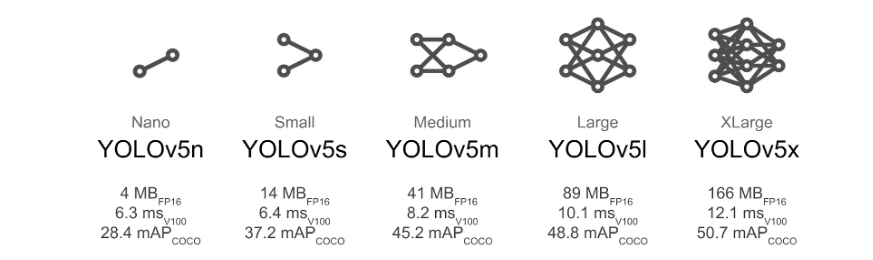

In [52]:
!python yolov5/train.py \
--img 640 \
--batch 10 \
--epochs 30 \
--data {DATA_CONFIG_PATH} \
--weights yolov5s.pt \
--name my_yolov5_model_s \
--entity None

train: weights=yolov5s.pt, cfg=, data=yolo/dataset.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=10, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=yolov5/data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=my_yolov5_model_s, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-420-g0c99ce80 Python-3.12.11 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 SUPER, 12282MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentu